In [2]:
##INPUT description
#
#This script requires two input files: 
#- the summary of the Benchflow tests ("dataFile") and 
#- the output file of the APM tools ("operationalProfile")
#
#The Benchflow tests must be run with Users==50,100,150,200,250,300 and the following 
#configurations:
#
# Memory CPU  Replicas
#    1.0 0.50 2
#    0.5 0.25 4
#    0.5 0.50 2
#    0.5 0.25 2
#    0.5 0.50 1
#    1.0 0.50 4
#    0.5 0.50 4
#    1.0 0.25 2
#    0.5 0.25 1
#    1.0 0.25 4
#    1.0 0.50 1
#    1.0 0.25 1
#
#To define the benchmark threshold, an additional test in Benchflow 
#must be run with Users=2, Memory=4 CPU=1 and Replicas=1
#
#dataFile must contains all the above tests, no matter the order
#dataFile has the following entry layout: ID,Users,Memory,CPU,CartReplicas,Metric,Microservice
#Metric has three possible string values: "Avg (sec)", "SD (sec)" and "Mix % (take failure into account)" 
#Microservice is the name of the microservice
#
#operationalProfile has the following entry layout: State - number of concurrent users,Frequency 
#

#To get warnings, comment this 
oldw <- getOption("warn")
options(warn = -1)


In [3]:
#Pre-requisites, comment these lines if you already installed the libraries
install.packages("RColorBrewer")
library("RColorBrewer")
#Create the Table 
library(ggplot2)
library(gridExtra)
install.packages("gridExtra")

ERROR: Error in install.packages("RColorBrewer"): unable to install packages


In [3]:
##SETTINGS

#Options
max.num.users <- 300

#Preprocessing
allDataFileContent = readLines("experiments_0.5_and_1GB_benchflow_output.csv")

#We export files with the sep=, header and R does not handle that
skipFirstLine = allDataFileContent[-1]
dataFile <- read.csv(textConnection(skipFirstLine), header=TRUE, sep=",")
operationalProfile <- read.csv("OperationalProfileData.csv", header=TRUE, sep=",")
usersLoad <- operationalProfile[,1]
accessCount <- operationalProfile[,2]
max.requests <- max(usersLoad)
scaleFactor <- max.num.users/max.requests
scaledUsersLoad <- floor(scaleFactor * usersLoad)
#Check the first column of dataFile
head(dataFile)
#Identify selected configurations from dataFile
mySettings <- unique(dataFile[,1:5])

ID,Users,Memory,CPU,CartReplicas,Metric,createOrder,basket,getCatalogue,getItem,⋯,tags,getCustomer,viewOrdersPage,cataloguePage,getRelated,addToCart,catalogueSize,getAddress,getCard,showDetails
1,150,1.0,0.50,2,Avg (sec),0.0110,0.0020,0.0630,0.0630,,0.0610,0.0280,0.0020,0.0600,0.0640,0.0030,0.0620,0.0240,0.0210,0.0020
1,150,1.0,0.50,2,SD (sec),0.0660,0.0020,0.2360,0.2330,,0.2300,0.1480,0.0020,0.2290,0.2350,0.0080,0.2310,0.1340,0.1250,0.0020
1,150,1.0,0.50,2,Mix % (take failure into account),0.0132,0.0132,0.1128,0.0960,,0.0303,0.1131,0.0261,0.0303,0.0435,0.0132,0.0303,0.0132,0.0132,0.0435
2,300,0.5,0.25,4,Avg (sec),0.0080,0.0020,0.0140,0.0170,,0.0140,0.0090,0.0010,0.0140,0.0170,0.0030,0.0140,0.0120,0.0070,0.0020
2,300,0.5,0.25,4,SD (sec),0.0280,0.0010,0.1000,0.1090,,0.0950,0.0640,0.0010,0.0980,0.1090,0.0070,0.0910,0.0800,0.0390,0.0020
2,300,0.5,0.25,4,Mix % (take failure into account),0.0130,0.0130,0.1132,0.0957,,0.0306,0.1133,0.0258,0.0307,0.0438,0.0130,0.0305,0.0130,0.0130,0.0436


In [4]:
##Create aggregate values (by fifty) of the user frequency from "operationalProfile" 
accessFrequency <- accessCount/sum(accessCount)
byFifty <- which(scaledUsersLoad %% 50 == 0)

binProb <- c()
for (i in 1:length(byFifty)) {
    if (i==1) {
        binProb[i] <- sum(accessFrequency[1:byFifty[i]])
    } else {
        binProb[i] <- sum(accessFrequency[(byFifty[i-1]+1):byFifty[i]])
    }
}

aggregatedValues <- matrix(c(scaledUsersLoad[byFifty], binProb), ncol=2, nrow=6, dimnames=list(c(1,2,3,4,5,6), c("Workload (number of users)", "Domain metric per workload")))

In [5]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

noMicroServices<-ncol(dataFile)-6
tempBench<-dataFile[dataFile$Users==2,]
benchSettings<-mySettings[mySettings$Users==2,]
avgVectorB<-tempBench[tempBench$Metric=="Avg (sec)",][,-c(1:6)]
SDVectorB<- tempBench[tempBench$Metric=="SD (sec)",][,-c(1:6)]
mixB<-tempBench[tempBench$Metric=="Mix % (take failure into account)",][,-c(1:6)]
threshold<-data.frame(benchSettings,avgVectorB+3*SDVectorB)
#Check the first line of the dataframe thereshold: it must be one line
head(threshold)

,ID,Users,Memory,CPU,CartReplicas,createOrder,basket,getCatalogue,getItem,getCart,⋯,tags,getCustomer,viewOrdersPage,cataloguePage,getRelated,addToCart,catalogueSize,getAddress,getCard,showDetails
205,69,2,4,1,1,0.03,0.002,0.008,0.027,0.074,,0.016,0.027,0.005,0.008,0.034,0.005,0.024,0.034,0.008,0.002


In [6]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

#Select relevant rows
usedSettings<-mySettings[!mySettings$Users==2,]
usedDataFile<-dataFile[!dataFile$Users==2,]
avg<-usedDataFile[usedDataFile$Metric=="Avg (sec)",-6]
SD<-usedDataFile[usedDataFile$Metric=="SD (sec)",-6]
mixTemp<-usedDataFile[usedDataFile$Metric=="Mix % (take failure into account)",-6]

#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
passCriteria<-avg
relativeMass<-c()
#colnames(passCriteria)<-c(colnames(dataFile[-6]))
mix<-as.data.frame(matrix(nrow=nrow(usedSettings), ncol=ncol(usedDataFile)-1))
for(j in 1:nrow(passCriteria)){
    mix[j,]<-mixTemp[j,]
    for(i in 6:(5+noMicroServices)){
        if(passCriteria[j,i]>threshold[i]){mix[j,i]<-0}
    }
    relativeMass[j]<-sum(mix[j,6:(5+noMicroServices)])
}
#Show first lines of passCriteria
head(passCriteria)

,ID,Users,Memory,CPU,CartReplicas,createOrder,basket,getCatalogue,getItem,getCart,⋯,tags,getCustomer,viewOrdersPage,cataloguePage,getRelated,addToCart,catalogueSize,getAddress,getCard,showDetails
1,1,150,1.0,0.50,2,0.011,0.002,0.063,0.063,0.044,,0.061,0.028,0.002,0.060,0.064,0.003,0.062,0.024,0.021,0.002
4,2,300,0.5,0.25,4,0.008,0.002,0.014,0.017,16.504,,0.014,0.009,0.001,0.014,0.017,0.003,0.014,0.012,0.007,0.002
7,3,250,1.0,0.50,2,0.056,0.002,0.432,0.426,0.317,,0.439,0.207,0.002,0.423,0.428,0.003,0.427,0.207,0.208,0.002
10,4,50,0.5,0.50,2,0.007,0.001,0.004,0.005,0.009,,0.005,0.005,0.001,0.004,0.005,0.003,0.005,0.005,0.005,0.001
13,5,300,0.5,0.25,2,0.053,0.002,0.414,0.417,0.512,,0.408,0.202,0.002,0.408,0.413,0.003,0.418,0.199,0.208,0.002
16,6,100,1.0,0.50,2,0.007,0.002,0.004,0.005,0.007,,0.005,0.005,0.001,0.004,0.005,0.003,0.005,0.005,0.005,0.001


In [7]:
#Compute the domain metric for each configuration
tempData<-usedSettings
tempData$relativeMass<-relativeMass
absoluteMass<-c()
for(j in 1:nrow(tempData)){
    absoluteMass[j]<-tempData[j,"relativeMass"]*aggregatedValues[match(tempData[j,"Users"], aggregatedValues[,1]),2]
}
tempData$absoluteMass<-absoluteMass
mySettingsUnique<-unique(tempData[3:5])
set<-list()
domainMetricList<-list()
for(i in 1:nrow(mySettingsUnique)){
    set[[i]]<-tempData[which(tempData[,3] == mySettingsUnique[i,1]&tempData[,4] == mySettingsUnique[i,2]&tempData[,5] == mySettingsUnique[i,3]),]
    domainMetricList[[i]]<-set[[i]][,c(2,7)][order(set[[i]][,c(2,7)][,1]),]
}
#Uncomment this to show first lines of domainMetricList
#head(domainMetricList)

[1] "Cumulative Domain Metric"


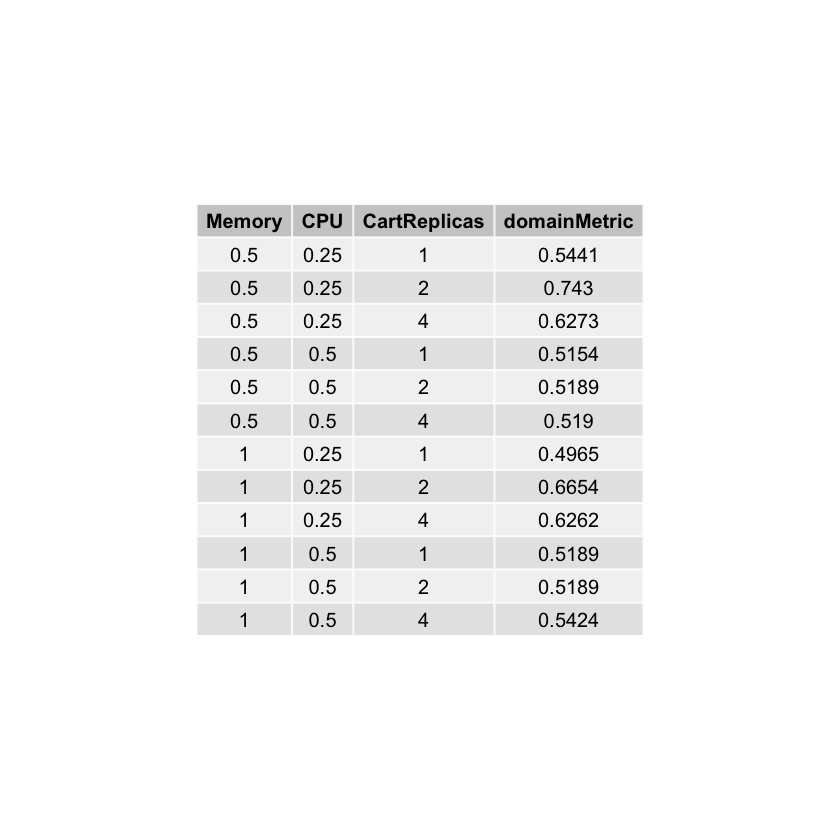

In [8]:
#Compute Cumulative Domain metric: summing up absoluteMass over users for each configuration
mySettingsUnique$domainMetric<-0
for(i in 1:nrow(mySettingsUnique)){
    mySettingsUnique[i,4]<-round(sum(tempData[which(tempData[,3] == mySettingsUnique[i,1]&tempData[,4] == mySettingsUnique[i,2]&tempData[,5] == mySettingsUnique[i,3]),"absoluteMass"]),4)
}
domainMetric<-mySettingsUnique
#Uncomment the following lines to save the Table
#pdf("Table.pdf", height=5, width=5)

p<-tableGrob(domainMetric[order(domainMetric[,1],domainMetric[,2],domainMetric[,3]),], rows=NULL)
grid.arrange(p)
#dev.off()
print("Cumulative Domain Metric")

NULL

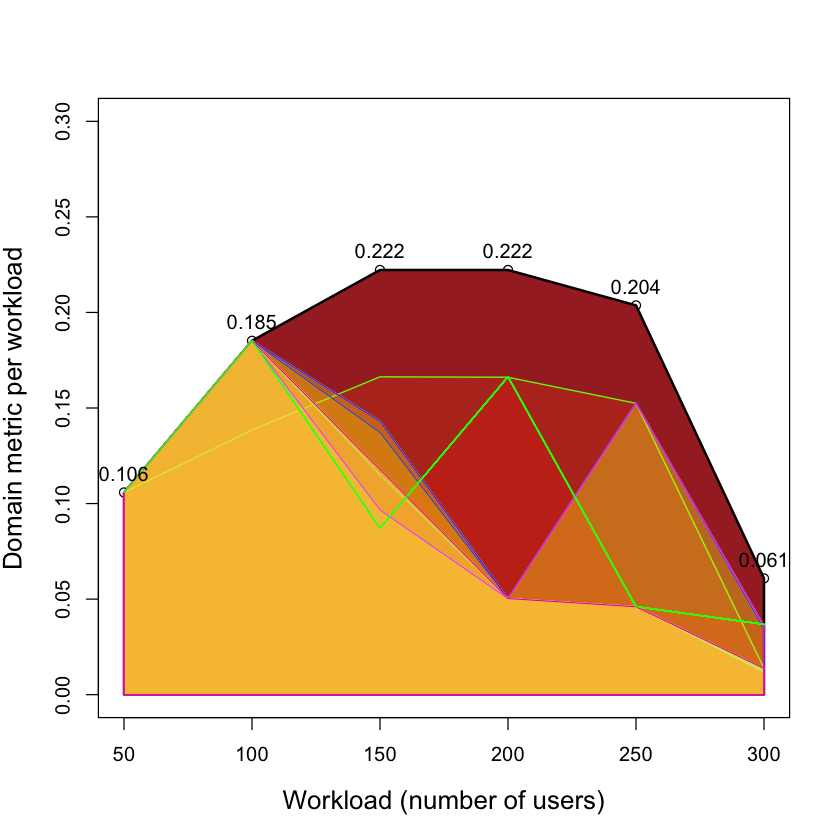

In [12]:
#Plot operationalProfile against domain metric for each configuration

plot(aggregatedValues, xlim=c(50, 300), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(50,aggregatedValues[,1],300),c(0,aggregatedValues[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

sortedDomainMetric<-domainMetric[order(domainMetric[,1],domainMetric[,2],domainMetric[,3]),]
k<-which(sortedDomainMetric[,4]==max(sortedDomainMetric[,4]))
#Green line whithin the polygon is the best domain matric line. 
#It corresponds to the second line in the final table below
for(i in 1:nrow(mySettingsUnique)) {
    lines(domainMetricList[[i]], type="l", col=heat.colors(11)[i])
    lines(domainMetricList[[k]], type="l", col="green")
    polygon(c(50,t(domainMetricList[[i]][1]),300),c(0,t(domainMetricList[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregatedValues,labels = round(aggregatedValues[1:6,2],3), pos=3, col="black")

#graphics.off()
options(warn = oldw)

NULL

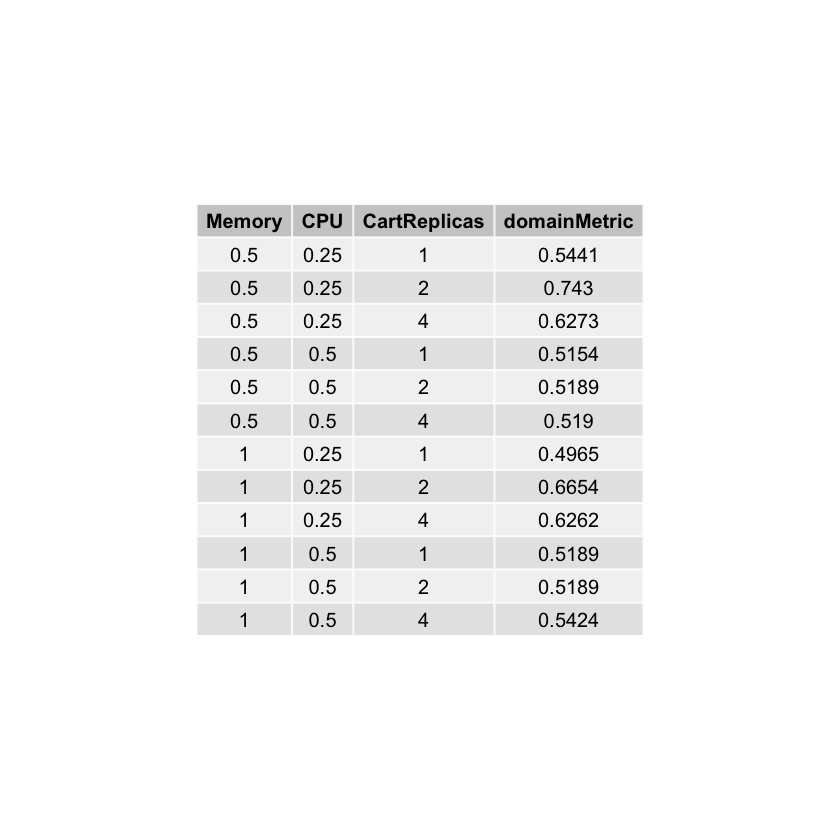

In [10]:
par(mfrow=c(2,1))
grid.arrange(p)
q